Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [162]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [163]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [164]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [140]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [165]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,4,ST. ALBANS,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,...,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019
23036,4,SUNNYSIDE,09 COOPS - WALKUP APARTMENTS,2,169,29,NaN,C6,"45-14 43RD STREET, 3C",NaN,...,0.0,0.0,0.0,0,0.0,1929.0,2,C6,355000,04/30/2019
23037,4,SUNNYSIDE,10 COOPS - ELEVATOR APARTMENTS,2,131,4,NaN,D4,"50-05 43RD AVENUE, 3M",NaN,...,0.0,0.0,0.0,0,0.0,1932.0,2,D4,375000,04/30/2019
23038,4,WOODHAVEN,02 TWO FAMILY DWELLINGS,1,8932,18,NaN,S2,91-10 JAMAICA AVE,NaN,...,2.0,1.0,3.0,"2,078",2200.0,1931.0,1,S2,1100000,04/30/2019


In [166]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [167]:
# Using a subset of the dataset restricting to building class category equivalent 
#to one family dwellings, with sale price between one hundred thousand and two million.

trained1 = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
             (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] > 100000)]
trained = trained1.drop(['EASE-MENT'], axis=1)
trained

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,ROSEDALE,01 ONE FAMILY DWELLINGS,1,13215,3,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11612,73,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11808,50,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,SPRINGFIELD GARDENS,01 ONE FAMILY DWELLINGS,1,12295,23,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019


In [168]:
train = trained[trained['SALE_DATE'] < '03/31/2019']
train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,NEW DORP-BEACH,01 ONE FAMILY DWELLINGS,1,4081,44,A2,10 SEAFOAM STREET,NaN,10306.0,1.0,0.0,1.0,"2,400",921.0,1950.0,1,A2,330000,03/29/2019
18130,5,NEW SPRINGVILLE,01 ONE FAMILY DWELLINGS,1,2373,201,A5,74 MCVEIGH AVE,NaN,10314.0,1.0,0.0,1.0,"2,450",2128.0,1980.0,1,A5,690000,03/29/2019
18132,5,PORT RICHMOND,01 ONE FAMILY DWELLINGS,1,1132,42,A1,479 VILLA AVENUE,NaN,10302.0,1.0,0.0,1.0,"4,361",1807.0,2018.0,1,A1,610949,03/29/2019
18134,5,SOUTH BEACH,01 ONE FAMILY DWELLINGS,1,3395,37,A2,63 NUGENT AVENUE,NaN,10305.0,1.0,0.0,1.0,"6,000",621.0,1930.0,1,A2,520000,03/29/2019


In [169]:
test = trained[trained['SALE_DATE'] > '03/31/2019']
test

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,RIVERDALE,01 ONE FAMILY DWELLINGS,1,5913,878,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,04/01/2019
18239,2,THROGS NECK,01 ONE FAMILY DWELLINGS,1,5488,48,A2,558 ELLSWORTH AVENUE,NaN,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,04/01/2019
18244,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,1,5936,31,A1,16 BAY RIDGE PARKWAY,NaN,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,04/01/2019
18280,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7813,24,A5,1247 EAST 40TH STREET,NaN,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,04/01/2019
18285,3,GERRITSEN BEACH,01 ONE FAMILY DWELLINGS,1,8831,160,A9,2314 PLUMB 2ND STREET,NaN,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,04/01/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,ROSEDALE,01 ONE FAMILY DWELLINGS,1,13215,3,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11612,73,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,SOUTH OZONE PARK,01 ONE FAMILY DWELLINGS,1,11808,50,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,SPRINGFIELD GARDENS,01 ONE FAMILY DWELLINGS,1,12295,23,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019


In [170]:
train.shape, test.shape

((2576, 20), (656, 20))

In [171]:
train['SALE_PRICE'].mean()

726925.0469720496

In [172]:
train.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.0,2.576000e+03
mean,6661.197593,75.322593,10988.782997,0.987966,0.018634,1.006599,1527.324146,1944.198758,1.0,7.269250e+05
std,3996.749137,155.687443,497.512425,0.109059,0.140879,0.179414,752.533920,27.390227,0.0,1.029368e+06
min,21.000000,1.000000,10009.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,3773.000000,21.000000,10314.000000,1.000000,0.000000,1.000000,1148.000000,1925.000000,1.0,4.450000e+05
50%,5973.000000,42.000000,11232.000000,1.000000,0.000000,1.000000,1377.500000,1940.000000,1.0,5.683000e+05
75%,9594.500000,70.000000,11412.000000,1.000000,0.000000,1.000000,1727.250000,1960.000000,1.0,7.800000e+05
max,16350.000000,2720.000000,11697.000000,1.000000,2.000000,3.000000,11224.000000,2018.000000,1.0,3.013936e+07


In [173]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2576,2576,2576,2576,2576,2576,2,2576,2576,2576
unique,5,195,1,2,14,2565,2,921,12,68
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,125-27 LUCAS STREET,RP.,"4,000",A1,01/31/2019
freq,1215,77,2576,2545,937,2,1,237,937,80


In [174]:
train['TAX_CLASS_AT_PRESENT'].value_counts()

1     2545
1D      31
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [175]:
train.groupby('TAX_CLASS_AT_PRESENT')['SALE_PRICE'].mean()

TAX_CLASS_AT_PRESENT
1     730993.721415
1D    392900.000000
Name: SALE_PRICE, dtype: float64

In [176]:
train['TAX_CLASS_AT_PRESENT'].unique()

array(['1', '1D'], dtype=object)

In [180]:
# Remove features with high cardinality.
target = 'SALE_PRICE'
high_cardinality = ['APARTMENT_NUMBER', 'NEIGHBORHOOD', 'ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)
features

Index(['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK',
       'LOT', 'BUILDING_CLASS_AT_PRESENT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [181]:
# To get a view of the data before encoding.
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_train.head()

,BOROUGH,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,01 ONE FAMILY DWELLINGS,1,5495,801,A9,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
61,4,01 ONE FAMILY DWELLINGS,1,7918,72,A1,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
78,2,01 ONE FAMILY DWELLINGS,1,4210,19,A1,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
108,3,01 ONE FAMILY DWELLINGS,1,5212,69,A1,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
111,3,01 ONE FAMILY DWELLINGS,1,7930,121,A5,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5


In [182]:
# Now we want to use one hot encoding on our categorical data.
# We will need to import category encoders.
import category_encoders as ce

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)
X_test_enc.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,...,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,1,0,5913,878,...,0,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,1,0,5488,48,...,0,0,1,0,0,0,0,0,0,0
18244,1,0,0,0,0,1,1,0,5936,31,...,0,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,1,0,7813,24,...,1,0,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,1,0,8831,160,...,0,0,0,0,0,0,0,0,0,0


In [183]:
X_test_enc.columns

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_PRESENT_A7', 'BUILDING_CLASS_AT_PRESENT_S1',
       'BUILDING_CLASS_AT_PRESENT_A4', 'BUILDING_CLASS_AT_PRESENT_A6',
       'BUILDING_CLASS_AT_PRESENT_A8', 'BUILDING_CLASS_AT_PRESENT_B2',
       'BUILDING_CLASS_AT_PRESENT_S0', 'BUILDING_CLASS_AT_PRESENT_B3',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CL

In [184]:
X_test_enc.isnull().sum()

BOROUGH_3                                          0
BOROUGH_4                                          0
BOROUGH_2                                          0
BOROUGH_5                                          0
BOROUGH_1                                          0
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS    0
TAX_CLASS_AT_PRESENT_1                             0
TAX_CLASS_AT_PRESENT_1D                            0
BLOCK                                              0
LOT                                                0
BUILDING_CLASS_AT_PRESENT_A9                       0
BUILDING_CLASS_AT_PRESENT_A1                       0
BUILDING_CLASS_AT_PRESENT_A5                       0
BUILDING_CLASS_AT_PRESENT_A0                       0
BUILDING_CLASS_AT_PRESENT_A2                       0
BUILDING_CLASS_AT_PRESENT_A3                       0
BUILDING_CLASS_AT_PRESENT_A7                       0
BUILDING_CLASS_AT_PRESENT_S1                       0
BUILDING_CLASS_AT_PRESENT_A4                  

In [200]:
def engineer_features(X):
    
    X = X.copy()
    
    feature_cols = ['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
                   'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
                   'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT']
    
    X['FEATURE_COUNT'] = X[feature_cols].sum(axis=1)
    X['TAX_CLASS'] = (X['TAX_CLASS_AT_PRESENT_1']==1) | (X['TAX_CLASS_AT_PRESENT_1D']==1)
    
    return X

X_train_eng = engineer_features(X_train_enc)
X_test_eng = engineer_features(X_test_enc)

In [202]:
features = X_train_eng.columns
n = len(features)
n

45

In [203]:
from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

combinations = sum(n_choose_k(n,k) for k in range(1,n+1))
print(f'{combinations:,.0f}')

35,184,372,088,831


In [204]:

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func = f_regression, k=25)
X_train_kbest = selector.fit_transform(X_train_eng, y_train)
X_test_kbest = selector.transform(X_test_eng)

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [205]:
mask = selector.get_support()
mask

array([ True,  True,  True,  True,  True, False, False, False,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
        True,  True,  True, False, False, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False])

In [206]:
X_train_eng.columns[mask]

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'BLOCK', 'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A2',
       'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_PRESENT_A7',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4',
       'BUILDING_CLASS_AT_PRESENT_S0', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A7',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S0', 'FEATURE_COUNT'],
      dtype='object')

In [207]:
X_train_eng.columns[~mask]

Index(['BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A0', 'BUILDING_CLASS_AT_PRESENT_A6',
       'BUILDING_CLASS_AT_PRESENT_A8', 'BUILDING_CLASS_AT_PRESENT_B2',
       'BUILDING_CLASS_AT_PRESENT_B3', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8', 'TAX_CLASS'],
      dtype='object')

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
mae_list =[]
for k in range(1, X_train_eng.shape[1]+1):
    print(f'{k} features')
    selector = SelectKBest(score_func = f_regression, k=15)
    X_train_kbest = selector.fit_transform(X_train_eng, y_train)
    X_test_kbest = selector.transform(X_test_eng)
    model = LinearRegression()
    model.fit(X_train_kbest, y_train)
    y_pred = model.predict(X_test_kbest)
    mae = mean_absolute_error(y_pred, y_test)
    print(f'MAE on test set: {mae:.2f}')
    mae_list.append(mae)

1 features
MAE on test set: 246494.21
2 features
MAE on test set: 246494.21
3 features
MAE on test set: 246494.21
4 features
MAE on test set: 246494.21
5 features
MAE on test set: 246494.21
6 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


7 features
MAE on test set: 246494.21
8 features
MAE on test set: 246494.21
9 features
MAE on test set: 246494.21
10 features
MAE on test set: 246494.21
11 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


12 features
MAE on test set: 246494.21
13 features
MAE on test set: 246494.21
14 features
MAE on test set: 246494.21
15 features
MAE on test set: 246494.21
16 features
MAE on test set: 246494.21
17 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


18 features
MAE on test set: 246494.21
19 features
MAE on test set: 246494.21
20 features
MAE on test set: 246494.21
21 features
MAE on test set: 246494.21
22 features
MAE on test set: 246494.21
23 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


24 features
MAE on test set: 246494.21
25 features
MAE on test set: 246494.21
26 features
MAE on test set: 246494.21
27 features
MAE on test set: 246494.21
28 features
MAE on test set: 246494.21
29 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


30 features
MAE on test set: 246494.21
31 features
MAE on test set: 246494.21
32 features
MAE on test set: 246494.21
33 features


C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk

MAE on test set: 246494.21
34 features
MAE on test set: 246494.21
35 features
MAE on test set: 246494.21
36 features
MAE on test set: 246494.21
37 features
MAE on test set: 246494.21
38 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


39 features
MAE on test set: 246494.21
40 features
MAE on test set: 246494.21
41 features
MAE on test set: 246494.21
42 features
MAE on test set: 246494.21
43 features
MAE on test set: 246494.21
44 features
MAE on test set: 246494.21

C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sk


45 features
MAE on test set: 246494.21


C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Aarons\Anaconda3\envs\unit2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


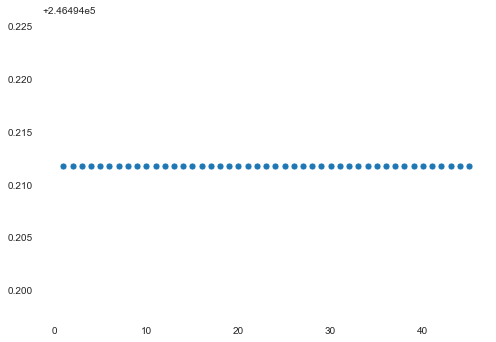

In [210]:
import seaborn as sns

sns.scatterplot(range(1, X_train_eng.shape[1]+ 1), mae_list);

In [213]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
%matplotlib inline

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    feature = 'TAX_CLASS_AT_PRESENT_1'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_eng[[features]], y_train)
    
    y_pred = model.predict(X_test_eng[[features]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    train.plot.scatter(features, target, alpha=0.05)
    plt.plot(X_test_eng[features], y_pred)
    plt.show()

KeyError: "None of [Index([('BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1', 'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS', 'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1', 'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0', 'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_PRESENT_A7', 'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4', 'BUILDING_CLASS_AT_PRESENT_A6', 'BUILDING_CLASS_AT_PRESENT_A8', 'BUILDING_CLASS_AT_PRESENT_B2', 'BUILDING_CLASS_AT_PRESENT_S0', 'BUILDING_CLASS_AT_PRESENT_B3', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9', 'BUILDING_CLASS_AT_TIME_OF_SALE_A1', 'BUILDING_CLASS_AT_TIME_OF_SALE_A5', 'BUILDING_CLASS_AT_TIME_OF_SALE_A0', 'BUILDING_CLASS_AT_TIME_OF_SALE_A2', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A7', 'BUILDING_CLASS_AT_TIME_OF_SALE_S1', 'BUILDING_CLASS_AT_TIME_OF_SALE_A4', 'BUILDING_CLASS_AT_TIME_OF_SALE_A6', 'BUILDING_CLASS_AT_TIME_OF_SALE_A8', 'BUILDING_CLASS_AT_TIME_OF_SALE_S0', 'FEATURE_COUNT', 'TAX_CLASS')], dtype='object')] are in the [columns]"